## Load fill and beam modes

In [1]:
import pytimber
import datetime
import pagestore
import time, calendar
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### Retrieve data from database and start analysis

In [2]:
%matplotlib notebook
db=pagestore.PageStore('/home/nbiancac/HDD/Work/MD/LHC/DB/lhc.db','/home/nbiancac/HDD/Work/MD/LHC/DB/')
import LHC_BBQ, LHC_BCT, LHC_Energy, LHC_Coll, LHC_BQM, LHC_BSRT, LHC_FBCT

filln=5130
output_path='/home/nbiancac/HDD/Work/MD/LHC/'+str(filln)+'/'
# os.mkdir(output_path)
tag=''
beam=1
ts1 = calendar.timegm(time.strptime("2016-07-29 04:20:00","%Y-%m-%d %H:%M:%S"))-2*3600
ts2 = calendar.timegm(time.strptime("2016-07-29 04:50:00","%Y-%m-%d %H:%M:%S"))-2*3600

<IPython.core.display.Javascript object>


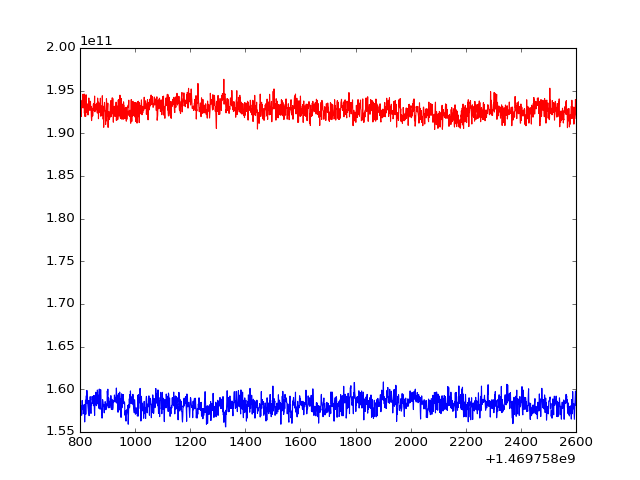

In [3]:
# BCT
import LHC_BCT
data=db.get(LHC_BCT.variable_list(beams=[1,2]),ts1,ts2)

plt.figure()
plt.plot(data['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'][0],data['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'][1])
plt.plot(data['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'][0],data['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'][1],'r')

del(data)

In [5]:
data=db.get(LHC_BSRT.variable_list(beams=[beam]),ts1,ts2)

import TimberManager as tm

varlist = LHC_BSRT.variable_list(beams=[beam])
print varlist
sigma_h = tm.timber_variable_list()
sigma_v = tm.timber_variable_list()
gate = tm.timber_variable_list()
sigma_h.t_stamps, sigma_h.values = data[varlist[0]]
sigma_v.t_stamps, sigma_v.values = data[varlist[1]]
sigma_v.t_str=[datetime.datetime.fromtimestamp(sigma_v.t_stamps[ii]) for ii in np.arange(len(sigma_v.t_stamps))]
gate.t_stamps, gate.values = data[varlist[2]]

dict_timber={}
dict_timber[varlist[0]]=sigma_h
dict_timber[varlist[1]]=sigma_v
dict_timber[varlist[2]]=gate
BSRT=LHC_BSRT.BSRT(dict_timber,beam=beam)



['LHC.BSRT.5R4.B1:FIT_SIGMA_H', 'LHC.BSRT.5R4.B1:FIT_SIGMA_V', 'LHC.BSRT.5R4.B1:GATE_DELAY']
expanding 0.0%


calc. emitt. 0.0%
calc. emitt. 29.6%
calc. emitt. 59.3%
calc. emitt. 88.9%


<IPython.core.display.Javascript object>


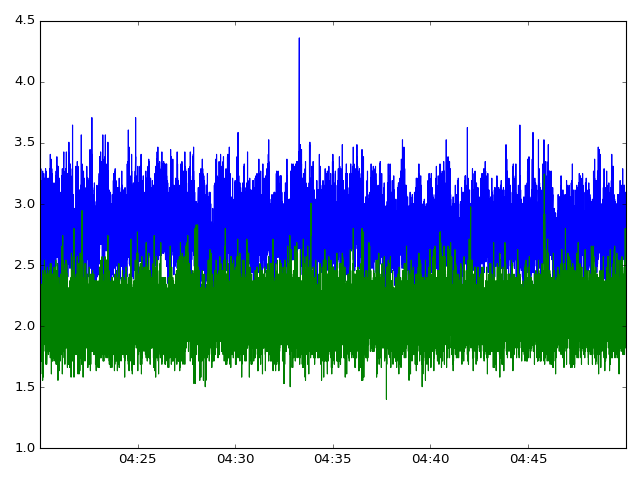

In [6]:
# Energy
data=db.get(LHC_Energy.variable_list(beams=[beam]),ts1,ts2)
Energy = LHC_Energy.energy(data, beam = beam)
LHC_Energy.variable_list(beams=[beam])
del(data)

BSRT.calculate_emittances(Energy)
plt.figure()

plt.plot(BSRT.t_str,BSRT.norm_emit_v)
plt.plot(BSRT.t_str,BSRT.norm_emit_h)
hfmt = mpl.dates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(hfmt)
plt.tight_layout()

In [9]:
# RAW BBQ
data=db.get(LHC_BBQ.variable_list_RAW(beams=[beam]),ts1,ts2)
BBQ_RAW=LHC_BBQ.BBQHS_RAW(data,beam=beam)
del(data)

<IPython.core.display.Javascript object>


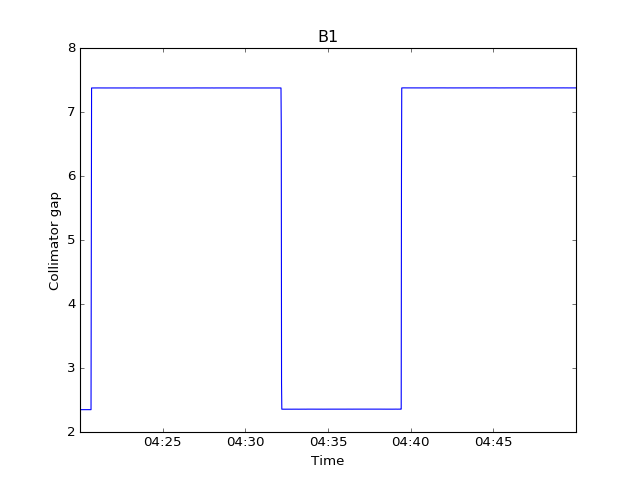

In [7]:
# Collimators
data=db.get(LHC_Coll.variable_list(beam),ts1,ts2)

Coll=LHC_Coll.Coll(data,beam=beam)
typecoll=['L','R']
Coll.select_coll('TCSG.D4'+typecoll[beam-1]+'7.B'+str(beam)+':MEAS_LVDT_GU')

plt.figure()
plt.plot(Coll.t_str, Coll.values, "-b")
plt.xlabel("Time")
plt.ylabel("Collimator gap")
plt.title('B%d'%(Coll.beam))
xfmt = mpl.dates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)

### BBQ spectrogram

<IPython.core.display.Javascript object>


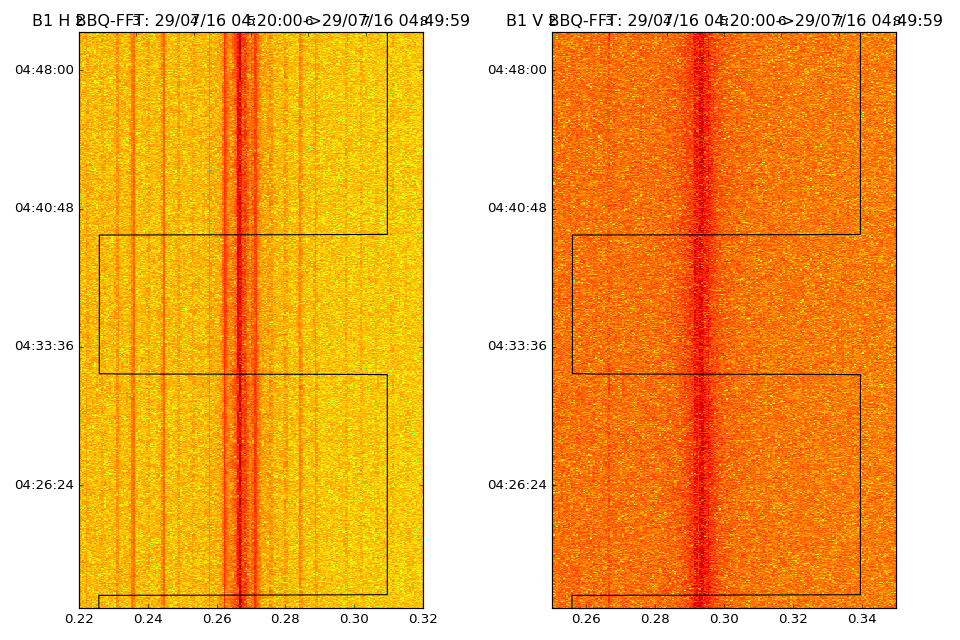

In [10]:
from scipy import signal

f, t, Sxx = signal.spectrogram(BBQ_RAW.h, fs = 1, nperseg = 2048, noverlap=0)

plt.figure(figsize=(12,8))
ax1 = plt.subplot(121)
mindate = mpl.dates.date2num(BBQ_RAW.t_str[0])
maxdate = mpl.dates.date2num(BBQ_RAW.t_str[-1])
plt.imshow(np.log10(np.squeeze(Sxx)), origin='lower', cmap='jet', interpolation='nearest', aspect='auto',
                extent=(0, 0.5, mindate, maxdate))

hfmt = mpl.dates.DateFormatter('%H:%M:%S')
plt.gca().yaxis.set_major_formatter(hfmt)

plt.title('B%d H BBQ-FFT: '%BBQ_RAW.beam +
    str(BBQ_RAW.t_str[0].strftime('%d/%m/%y %H:%M:%S')) +'->'+
      str(BBQ_RAW.t_str[-1].strftime('%d/%m/%y %H:%M:%S')))

plt.xlim(0.22, 0.32)

# with collimators
ax2 = ax1.twiny()
ax2.plot(Coll.values, Coll.t_str,"-k")
ax2.set_ylim(Coll.t_str[0], Coll.t_str[-1])

f, t, Syy = signal.spectrogram(BBQ_RAW.v, fs = 1, nperseg = 2048, noverlap=0)

ax1 = plt.subplot(122)
mindate = mpl.dates.date2num(BBQ_RAW.t_str[0])
maxdate = mpl.dates.date2num(BBQ_RAW.t_str[-1])
plt.imshow(np.log10(np.squeeze(Syy)), origin='lower', cmap='jet', interpolation='nearest', aspect='auto',
                extent=(0, 0.5, mindate, maxdate))

hfmt = mpl.dates.DateFormatter('%H:%M:%S')
plt.gca().yaxis.set_major_formatter(hfmt)

plt.title('B%d V BBQ-FFT: '%BBQ_RAW.beam +
    str(BBQ_RAW.t_str[0].strftime('%d/%m/%y %H:%M:%S')) +'->'+
      str(BBQ_RAW.t_str[-1].strftime('%d/%m/%y %H:%M:%S')))

plt.xlim(0.25, 0.35)


del(Sxx,Syy)
# with collimators
ax2 = ax1.twiny()
ax2.plot(Coll.values, Coll.t_str,"-k")
ax2.set_ylim(Coll.t_str[0], Coll.t_str[-1])

plt.tight_layout()

### Sussix

In [29]:
import PySussix as ps

# Sussix settings
nt1=1; nt2=4096;
nharm = 15

tunex0 = 0.27
tuney0 = 0.295
ex0 = 1e-3
ey0 = 1e-3

tuney_vec=[];tunex_vec=[];
spec_ox=[]; spec_oy=[];
spec_ax=[]; spec_ay=[];
spec_t=[];

for ii in np.arange(0, len(BBQ_RAW.v)):
    
    datax=BBQ_RAW.h[ii][nt1:nt2]-np.mean(BBQ_RAW.h[ii][nt1:nt2])
    datay=BBQ_RAW.v[ii][nt1:nt2]-np.mean(BBQ_RAW.v[ii][nt1:nt2])
    spec=ps.Sussix()
    spec.sussix_inp(nt1=nt1,nt2=nt2,tunex=tunex0,tuney=tuney0,ex=ex0,ey=ey0,ir=1,nharm=nharm)
    spec.sussix(datax,0*datax, 
                datay, 0*datay, 
                0*datax, 0*datay)
    

    
    spec.ox=np.abs(spec.ox)
    spec.oy=np.abs(spec.oy)
    
    spec_ox.append(spec.ox[0:nharm-1])
    spec_oy.append(spec.oy[0:nharm-1])
    spec_ax.append(spec.ax[0:nharm-1])
    spec_ay.append(spec.ay[0:nharm-1])
    spec_t.append(BBQ_RAW.t_stamps[ii]*(1+np.random.randn(1,nharm-1)*1e-12))
    
    del(datax,datay)

/home/nbiancac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 600 but corresponding boolean dimension is 4
/home/nbiancac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 600 but corresponding boolean dimension is 11
/home/nbiancac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 600 but corresponding boolean dimension is 8
/home/nbiancac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 600 but corresponding boolean dimension is 8
/home/nbiancac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWa

In [57]:
[tunex_min, tunex_max] = [0.2673 , 0.2692]
[tuney_min, tuney_max] = [0.2923 , 0.2947]

rangex=np.array([tunex_min, tunex_max])
rangey=np.array([tuney_min, tuney_max])

tuney_vec=[]

for ii,index in enumerate((np.abs(spec_oy) < rangey.max()) & (np.abs(spec_oy) > rangey.min())):
    spec.oy = np.squeeze(spec_oy[ii])[index]
    spec.ay = np.squeeze(spec_ay[ii])[index]
    
    if len(spec.ay):
        tuney=spec.oy[spec.ay.argmax()]
    else:
        tuney=np.NaN
    tuney_vec.append(tuney)

BBQ_RAW.qv=np.array(tuney_vec)

tunex_vec=[]

for ii,index in enumerate((np.abs(spec_ox) < rangex.max()) & (np.abs(spec_ox) > rangex.min())):
    spec.ox = np.squeeze(spec_ox[ii])[index]
    spec.ax = np.squeeze(spec_ax[ii])[index]
    
    if len(spec.ax):
        tunex=spec.ox[spec.ax.argmax()]
    else:
        tunex=np.NaN
    tunex_vec.append(tunex)

BBQ_RAW.qh=np.array(tunex_vec)

<IPython.core.display.Javascript object>


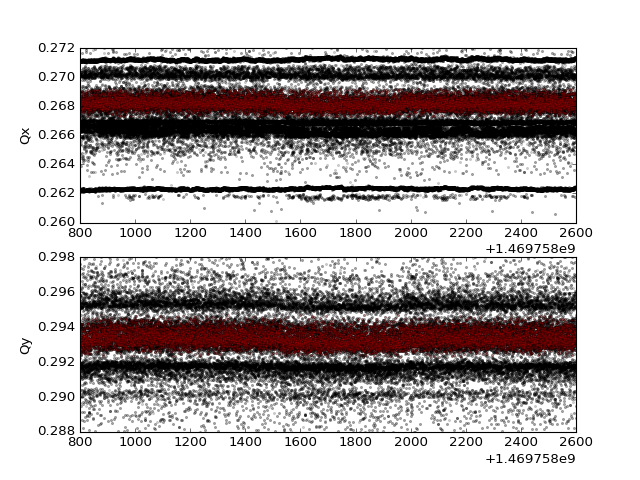

(0.288, 0.298)

In [58]:
# plot tunes
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.squeeze(np.reshape(np.asarray(spec_t),(1,-1))),np.squeeze(np.reshape(np.asarray(spec_ox),(1,-1))),'ok',alpha=0.2,markerfacecolor='k', markersize=2)
plt.plot(BBQ_RAW.t_stamps,BBQ_RAW.qh,'or',alpha=0.2,markerfacecolor='r', markersize=2)
plt.ylabel('Qx')
plt.ylim(0.26 ,0.272)

plt.subplot(2,1,2)
plt.plot(np.squeeze(np.reshape(np.asarray(spec_t),(1,-1))),np.squeeze(np.reshape(np.asarray(spec_oy),(1,-1))),'ok',alpha=0.2,markerfacecolor='k',markersize=2)
plt.plot(BBQ_RAW.t_stamps,BBQ_RAW.qv,'or',alpha=0.2,markerfacecolor='r', markersize=2)
plt.ylabel('Qy')
plt.ylim(0.288 ,0.298)

# del(spec_ox, spec_ox)

### Interpolate gaps on tune data

In [60]:
# Get rid of the nans...
ind_nan=~np.isnan(BBQ_RAW.qh) & ~np.isnan(BBQ_RAW.qv)
temp_h=BBQ_RAW.qh[ind_nan]
temp_v=BBQ_RAW.qv[ind_nan]
temp_t_stamps=BBQ_RAW.t_stamps[ind_nan]
temp_t_str= np.array(BBQ_RAW.t_str)[ind_nan]

BBQ_RAW.qh=temp_h;
BBQ_RAW.qv=temp_v;
BBQ_RAW.t_stamps= temp_t_stamps
BBQ_RAW.t_str= temp_t_str


# Interpolate collgaps on BBQ timestamps
Coll.interp_with(BBQ_RAW)
len(Coll.t_str), len(BBQ_RAW.t_str)

(9488, 9488)

<IPython.core.display.Javascript object>


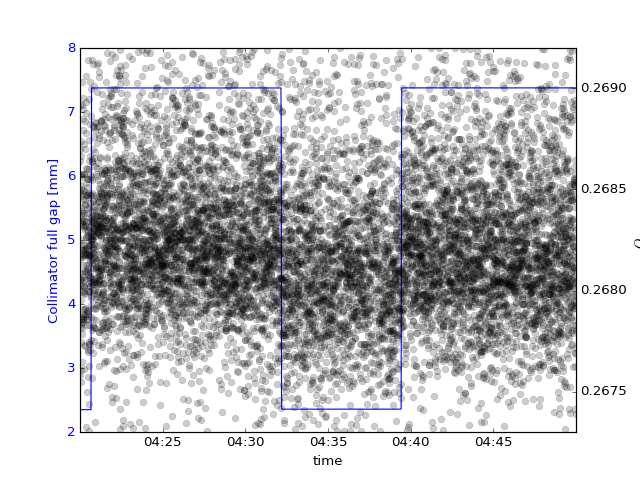

<IPython.core.display.Javascript object>


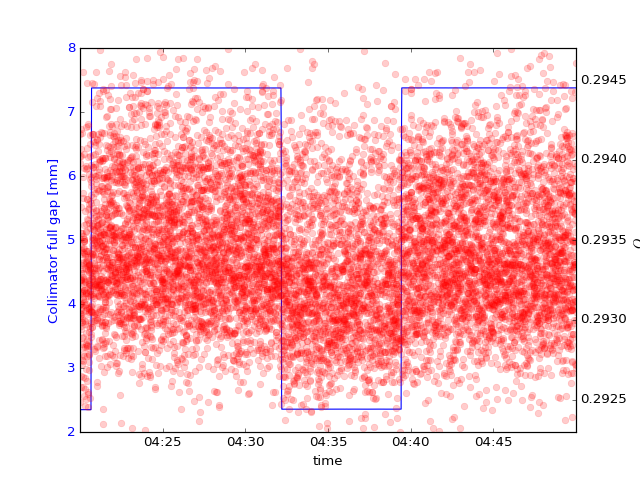

(0.2923, 0.29470000000000002)

In [62]:
fig, ax1 = plt.subplots()
ax1.plot(Coll.t_str, Coll.values, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qh,  'ok',alpha=0.2,markerfacecolor='k',markeredgecolor='k')
ax2.set_ylabel('$Q_x$', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangex.min(), rangex.max())

fig, ax1 = plt.subplots()
ax1.plot(Coll.t_str, Coll.values, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qv,  'or',alpha=0.2,markerfacecolor='r',markeredgecolor='r')
ax2.set_ylabel('$Q_y$', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangey.min(), rangey.max())

### Moving average

<IPython.core.display.Javascript object>


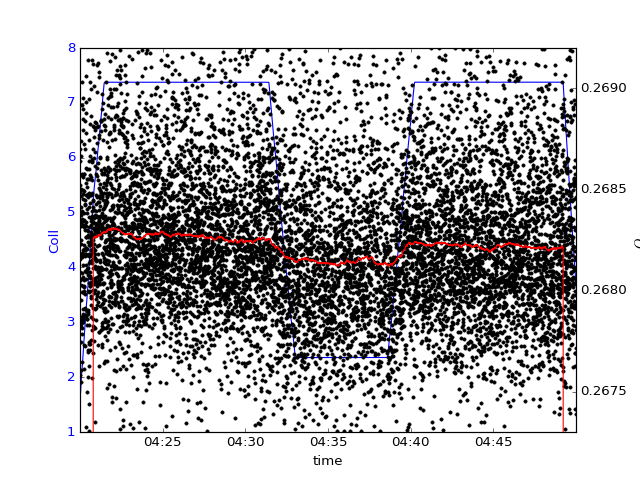

<IPython.core.display.Javascript object>


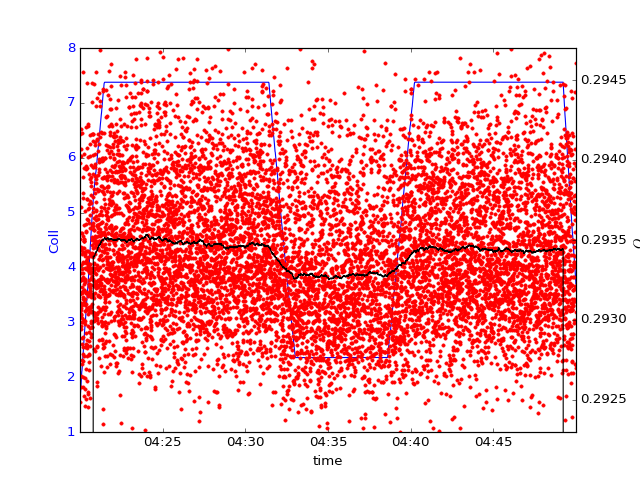

(0.2923, 0.29470000000000002)

In [73]:
N=500

BBQ_RAW.qv_ma=np.convolve(np.ravel(BBQ_RAW.qv), np.ones((N,))/N,mode='same')

BBQ_RAW.qh_ma=np.convolve(np.ravel(BBQ_RAW.qh), np.ones((N,))/N,mode='same')

Coll.values_ma=np.convolve(np.ravel(Coll.values), np.ones((N,))/N,mode='same')

fig, ax1 = plt.subplots()
ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Coll', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qh, 'k.')
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qh_ma, '-r')
ax2.set_ylabel('$Q_x$', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangex.min(), rangex.max())

fig, ax1 = plt.subplots()
ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Coll', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qv, 'r.')
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qv_ma, '-k')
ax2.set_ylabel('$Q_y$', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangey.min(), rangey.max())



In [72]:
1.05*Coll.values.min()

2.4660136803201036

<IPython.core.display.Javascript object>


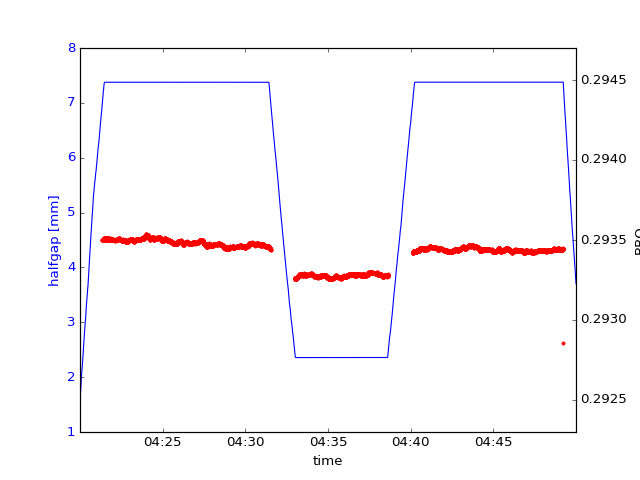

In [75]:
gu=0.95*Coll.values.max();
gd=1.05*Coll.values.min()

mask=(Coll.values_ma>gu) #| (Coll.values>gu)

fig, ax1 = plt.subplots()
ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('halfgap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(np.array(BBQ_RAW.t_str)[mask], BBQ_RAW.qv_ma[mask], 'r.')
ax2.set_ylabel('BBQ', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangey.min(), rangey.max())

mask=(Coll.values_ma<gd) #| (Coll.values<gd)
ax2.plot(np.array(BBQ_RAW.t_str)[mask], BBQ_RAW.qv_ma[mask], 'r.')

In [83]:
tag = 'all_TCSG7'

<IPython.core.display.Javascript object>


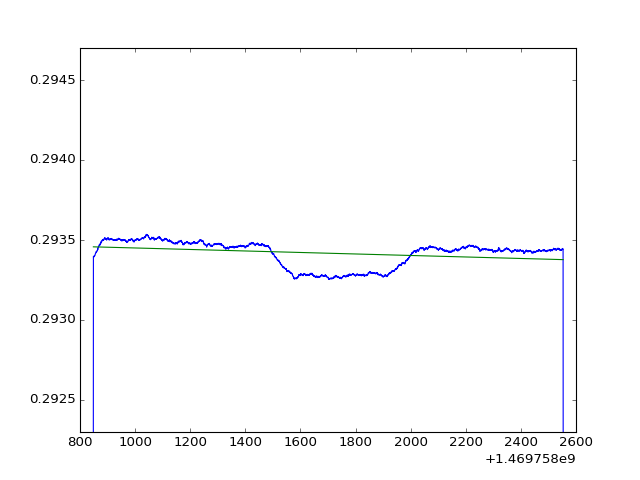

<IPython.core.display.Javascript object>


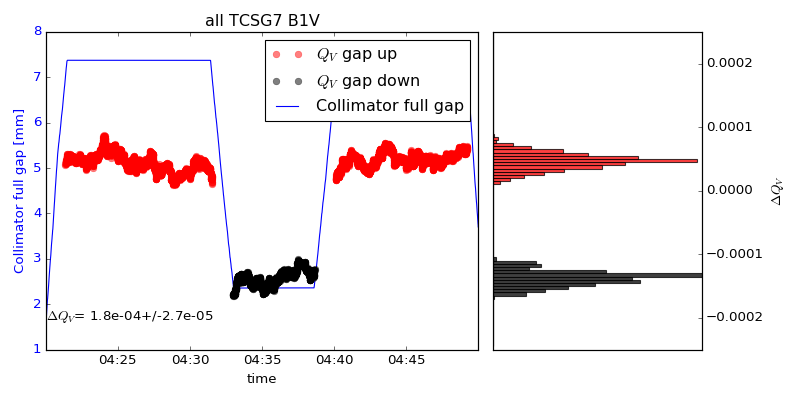

4.6e-05+/-1.5e-05
-1.4e-04+/-1.2e-05
tune shift: 1.8e-04+/-2.7e-05


'/home/nbiancac/HDD/Work/MD/LHC/5130/all_TCSG7_vs_gap_B1V.pdf'

In [84]:
gu=0.95*Coll.values.max();
gd=1.05*Coll.values.min()
plane='V'

# get out slope from measurement
x=BBQ_RAW.t_stamps
y=BBQ_RAW.qv_ma

mask_tune=(y<tuney_max) & (y>tuney_min)
p=np.polyfit(x[mask_tune],y[mask_tune],1)
slope=p[0]
intercept=p[1]
fit=slope*x+intercept

plt.figure()
plt.plot(BBQ_RAW.t_stamps,BBQ_RAW.qv_ma)
plt.plot(BBQ_RAW.t_stamps[mask_tune],fit[mask_tune])
plt.ylim(tuney_min, tuney_max)

# Upper gap
mask1=(Coll.values_ma>gu) 
x=BBQ_RAW.t_stamps[mask1]
y=BBQ_RAW.qv_ma[mask1]
fit1=fit[mask1]

mask_tune=(y<tuney_max) & (y>tuney_min)

y1=y-fit1
y1_mean=np.mean(y1[mask_tune])
y1_std=np.std(y1[mask_tune])

# Lower gap
mask2=(Coll.values_ma<gd) 
x=BBQ_RAW.t_stamps[mask2]
y=BBQ_RAW.qv_ma[mask2]

fit2=fit[mask2]
mask_tune=(y<tuney_max) & (y>tuney_min)

y2=y-fit2
y2_mean=np.mean(y2[mask_tune])
y2_std=np.std(y2[mask_tune])

ts_mean=y1_mean- y2_mean
ts_std=y1_std+y2_std

plt.figure(figsize=(10,5), facecolor='white')
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
h2, = ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)
ax1.annotate('$\Delta Q_'+plane+'$= %.1e+/-%.1e'%(ts_mean,ts_std),xy=(Coll.t_str[5], Coll.values_ma[5]))
plt.title(tag.replace('_',' ')+' B'+str(beam)+plane)
ax2 = ax1.twinx()
h0, = ax2.plot(np.array(BBQ_RAW.t_str)[mask1], y1, 'or',alpha=0.5,markerfacecolor='r',markeredgecolor='r')
h1, = ax2.plot(np.array(BBQ_RAW.t_str)[mask2][mask_tune], y2[mask_tune], 'ok',alpha=.5,markerfacecolor='k',markeredgecolor='k')
ax2.set_ylim(-2.5e-4, 2.5e-4)
ax2.yaxis.set_ticks([])

plt.legend([h0, h1, h2],['$Q_'+plane+'$ gap up' , '$Q_'+plane+'$ gap down', 'Collimator full gap'])


# distribution
ax1 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax1.set_ylim(-2.5e-4, 2.5e-4)
ax1.yaxis.set_ticks([])
ax1.xaxis.set_ticks([])

ax2=ax1.twinx()
n, bins, patches = plt.hist(y1, 100, range = (-2.5e-4, 2.5e-4), normed=1, facecolor='r', alpha=0.75, orientation="horizontal")
n, bins, patches = plt.hist(y2, 100, range = (-2.5e-4, 2.5e-4), normed=1, facecolor='k', alpha=0.75, orientation="horizontal")
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks([-2e-4, -1e-4, 0, 1e-4, 2e-4])
ax2.set_ylabel('$\Delta Q_'+plane+'$')
ax2.set_ylim(-2.5e-4, 2.5e-4)
plt.tight_layout()


print '%.1e+/-%.1e'%(y1_mean,y1_std)
print '%.1e+/-%.1e'%(y2_mean,y2_std)
print 'tune shift: %.1e+/-%.1e'%(ts_mean,ts_std)

plt.savefig(output_path+tag+'_vs_gap_B'+str(beam)+plane+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_vs_gap_B'+str(beam)+plane+'.png', transparent=True)
output_path+tag+'_vs_gap_B'+str(beam)+plane+'.pdf'

<IPython.core.display.Javascript object>


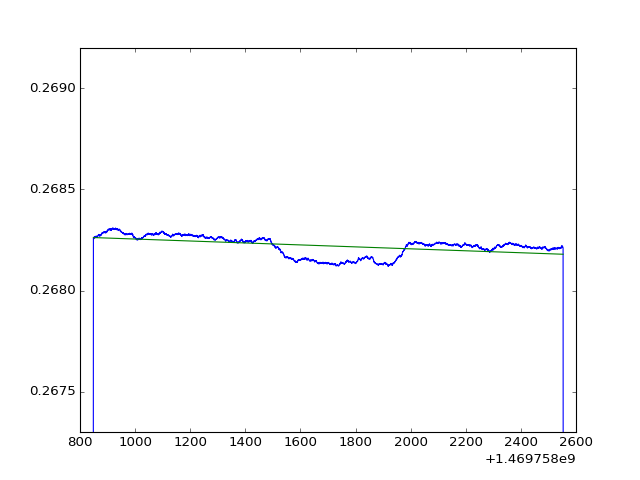

<IPython.core.display.Javascript object>


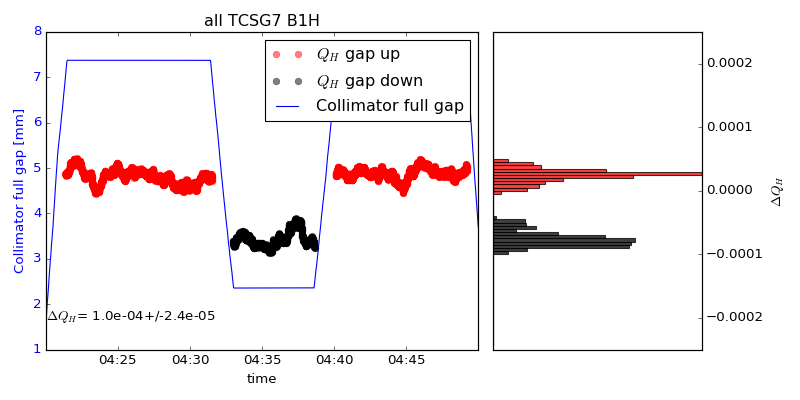

2.5e-05+/-1.2e-05
-7.6e-05+/-1.2e-05
tune shift: 1.0e-04+/-2.4e-05


'/home/nbiancac/HDD/Work/MD/LHC/5130/all_TCSG7_vs_gap_B1H.pdf'

In [85]:
gu=0.95*Coll.values.max();
gd=1.05*Coll.values.min()
plane='H'

# get out slope from measurement
x=BBQ_RAW.t_stamps
y=BBQ_RAW.qh_ma

mask_tune=(y<tunex_max) & (y>tunex_min)
p=np.polyfit(x[mask_tune],y[mask_tune],1)
slope=p[0]
intercept=p[1]
fit=slope*x+intercept

plt.figure()
plt.plot(BBQ_RAW.t_stamps,BBQ_RAW.qh_ma)
plt.plot(BBQ_RAW.t_stamps[mask_tune],fit[mask_tune])
plt.ylim(tunex_min, tunex_max)

# Upper gap
mask1=(Coll.values_ma>gu) 
x=BBQ_RAW.t_stamps[mask1]
y=BBQ_RAW.qh_ma[mask1]
fit1=fit[mask1]

mask_tune=(y<tunex_max) & (y>tunex_min)

y1=y-fit1
y1_mean=np.mean(y1[mask_tune])
y1_std=np.std(y1[mask_tune])

# Lower gap
mask2=(Coll.values_ma<gd) 
x=BBQ_RAW.t_stamps[mask2]
y=BBQ_RAW.qh_ma[mask2]

fit2=fit[mask2]
mask_tune=(y<tunex_max) & (y>tunex_min)

y2=y-fit2
y2_mean=np.mean(y2[mask_tune])
y2_std=np.std(y2[mask_tune])

ts_mean=y1_mean- y2_mean
ts_std=y1_std+y2_std

plt.figure(figsize=(10,5), facecolor='white')
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
h2, = ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)
ax1.annotate('$\Delta Q_'+plane+'$= %.1e+/-%.1e'%(ts_mean,ts_std),xy=(Coll.t_str[5], Coll.values_ma[5]))
plt.title(tag.replace('_',' ')+' B'+str(beam)+plane)
ax2 = ax1.twinx()
h0, = ax2.plot(np.array(BBQ_RAW.t_str)[mask1], y1, 'or',alpha=0.5,markerfacecolor='r',markeredgecolor='r')
h1, = ax2.plot(np.array(BBQ_RAW.t_str)[mask2][mask_tune], y2[mask_tune], 'ok',alpha=.5,markerfacecolor='k',markeredgecolor='k')
ax2.set_ylim(-2.5e-4, 2.5e-4)
ax2.yaxis.set_ticks([])

plt.legend([h0, h1, h2],['$Q_'+plane+'$ gap up' , '$Q_'+plane+'$ gap down', 'Collimator full gap'])



# distribution
ax1 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax1.set_ylim(-2.5e-4, 2.5e-4)
ax1.yaxis.set_ticks([])
ax1.xaxis.set_ticks([])

ax2=ax1.twinx()
n, bins, patches = plt.hist(y1, 100, range = (-2.5e-4, 2.5e-4), normed=1, facecolor='r', alpha=0.75, orientation="horizontal")
n, bins, patches = plt.hist(y2, 100, range = (-2.5e-4, 2.5e-4), normed=1, facecolor='k', alpha=0.75, orientation="horizontal")
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks([-2e-4, -1e-4, 0, 1e-4, 2e-4])
ax2.set_ylabel('$\Delta Q_'+plane+'$')
ax2.set_ylim(-2.5e-4, 2.5e-4)
plt.tight_layout()


print '%.1e+/-%.1e'%(y1_mean,y1_std)
print '%.1e+/-%.1e'%(y2_mean,y2_std)
print 'tune shift: %.1e+/-%.1e'%(ts_mean,ts_std)

plt.savefig(output_path+tag+'_vs_gap_B'+str(beam)+plane+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_vs_gap_B'+str(beam)+plane+'.png', transparent=True)
output_path+tag+'_vs_gap_B'+str(beam)+plane+'.pdf'